<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_10_Final_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier,Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

In [64]:
METHOD_LIST = ['lightgbm', 'xgboost', 'catboost']
n_folds = 7
seed = 42
models_xgb=[]
models_cat=[]
models_lgb=[]
params_xgb = {'max_depth': 7,
        'gamma': 2,
        'colsample_bytree' : 0.6,
        'min_child_weight' : 4,
        'n_estimators': 1000,
        'seed': 42,
        'eta':0.05,
    }

params_lgb={
    'learning_rate': 0.05,
    "metric": "None",
    "num_iterations": 1000,
    "first_metric_only": True,
    "verbose": 1,
    "num_leaves": 4,
        }

best_threshold_all = []

In [7]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)
df_id3 = pd.read_csv('/content/drive/MyDrive/WB_стажировка/MAIN/db_agg_by_id3.csv')

In [8]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [9]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [10]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})
df1 = pd.merge(df,df_agg,how='left',on=['id3'])
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [11]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [ ]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)
df1 = df1.assign(**feature_dict)

In [13]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [15]:
N_SPLITS = 7
current_feat = list(X.columns[:8])
best_threshold_all = 0

In [16]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [56]:
def f1(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred> 0.5).astype('int')
    nc = np.bincount(y_true.astype(int))
    f1 = f1_score(y_true, y_pred,average='macro')
    return "f1",f1,True

def f1_xgb(predt: np.ndarray, dtrain: xgb.DMatrix):
    y_true = dtrain.get_label()
    y_pred = (predt> 0.5).astype('int')
    nc = np.bincount(y_true.astype(int))
    f1 = f1_score(y_true, y_pred,average='macro')
    return 'f1', f1

def calc_log_loss_weight(y_true):
    y_true = y_true.astype(int)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

def plot(scores,best_score,thresholds,best_threshold,text):
  plt.figure(figsize=(20,5))
  plt.plot(thresholds,scores,'-o',color='blue')
  plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
  plt.xlabel('Threshold',size=14)
  plt.ylabel(f'Validation {text}',size=14)
  plt.title(f'Threshold vs. {text} with Best {text}= {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
  plt.show()

def tresh_search(oof,):
  scores_f1_score=[]
  thresholds = []
  best_f1= 0; best_threshold = 0
  true = y_train
  for threshold in np.arange(0.05,0.97,0.001):
      preds = (oof.values.reshape((-1))>threshold).astype('int')
      f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
      scores_f1_score.append(f1)
      thresholds.append(threshold)
      if f1>best_f1:
          best_f1 = f1
          best_threshold = threshold
  scores_dict = {'f1_score':[scores_f1_score,best_f1],}
  plot(scores_dict['f1_score'][0],scores_dict['f1_score'][1],thresholds,best_threshold,'f1_score')
  return best_threshold

def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    lgb_train = lgb.Dataset(x_train, y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
    lgb_valid = lgb.Dataset(x_valid, y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))
    early = lgb.early_stopping(50, first_metric_only=False, verbose=True)
    model = lgb.train(
                    params_lgb,
                    train_set=lgb_train,
                    valid_sets=[lgb_valid],
                    feval=f1,
                    callbacks=[early],
                    verbose_eval=False
                  )

    valid_pred = model.predict(x_valid)
    return model, valid_pred
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    xgb_train = xgb.DMatrix(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))
    model = xgb.train(
                params_xgb,
                dtrain = xgb_train,
                num_boost_round = 2000,
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                early_stopping_rounds = 100,
                verbose_eval = 0,
                custom_metric = f1_xgb,
            )

    valid_pred = model.predict(xgb.DMatrix(data=x_valid[columns]))
    return model, valid_pred

def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    cat_train = Pool(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
    cat_valid = Pool(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))
    model = CatBoostClassifier()
    model.fit(cat_train,
              eval_set=[cat_valid],
              verbose=0,
              use_best_model=True)

    valid_pred = model.predict_proba(x_valid)[:, 1]
    return model, valid_pred

def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list,best_threshold_all):

    indx_all = X_train.index
    cv_scores_AUC_ROC = np.empty(n_folds)
    cv_scores_f1_score = np.empty(n_folds)
    cv_scores_Precision = np.empty(n_folds)
    cv_scores_Recall = np.empty(n_folds)
    cv_scores = np.empty(n_folds)
    roc_auc_score_1 = np.empty(n_folds)
    oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)

    cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 22)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        print('-'*50)
        print(f'{method} training fold {idx + 1}')

        X_train_сv, X_val_сv = X_train[columns].iloc[train_idx], X_train[columns].iloc[test_idx]
        y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(X_train_сv, y_train_сv, X_val_сv, y_val_сv, features, )
            models_lgb.append(model)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(X_train_сv, y_train_сv, X_val_сv, y_val_сv, features, )
            models_xgb.append(model)
        if method == 'catboost':
            model, valid_pred = catboost_training(X_train_сv, y_train_сv, X_val_сv, y_val_сv, features, )
            models_cat.append(model)

        y_pred_metki = (valid_pred> 0.5).astype('int')
        oof.loc[X_val_сv.index,0] = valid_pred
        precision = precision_score(y_val_сv, y_pred_metki)
        recall = recall_score(y_val_сv, y_pred_metki)
        cv_scores_AUC_ROC[idx] = roc_auc_score(y_val_сv, valid_pred)
        cv_scores_f1_score[idx] = f1_score(y_val_сv, y_pred_metki,average='macro')
        cv_scores_Precision[idx] = precision
        cv_scores_Recall[idx] = recall

    print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
    print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
    print("Precision-----"+str(np.mean(cv_scores_Precision)))
    print("Recall-----"+str(np.mean(cv_scores_Recall)))
    best_threshold_all.append(tresh_search(oof))

--------------------------------------------------
lightgbm training fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3673
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[77]	valid_0's f1: 0.675612
--------------------------------------------------
lightgbm training fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3671
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[17]	valid_0's f1: 0.663914
--------------------------------------------------
lightgbm training fold 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[156]	valid_0's f1: 0.649399
--------------------------------------------------
lightgbm training fold 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[31]	valid_0's f1: 0.663232
--------------------------------------------------
lightgbm training fold 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[10]	valid_0's f1: 0.665138
--------------------------------------------------
lightgbm training fold 6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3676
[LightGBM] [Info] Number of data points in the train set: 2141, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[160]	valid_0's f1: 0.642982
--------------------------------------------------
lightgbm training fold 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3679
[LightGBM] [Info] Number of data points in the train set: 2141, number of used features: 17
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[113]	valid_0's f1: 0.673336
AUC_ROC----0.7324103701414332
F1-score-----0.6619448234995773
Precision-----0.46923950872716125
Recall-----0.606015037593985


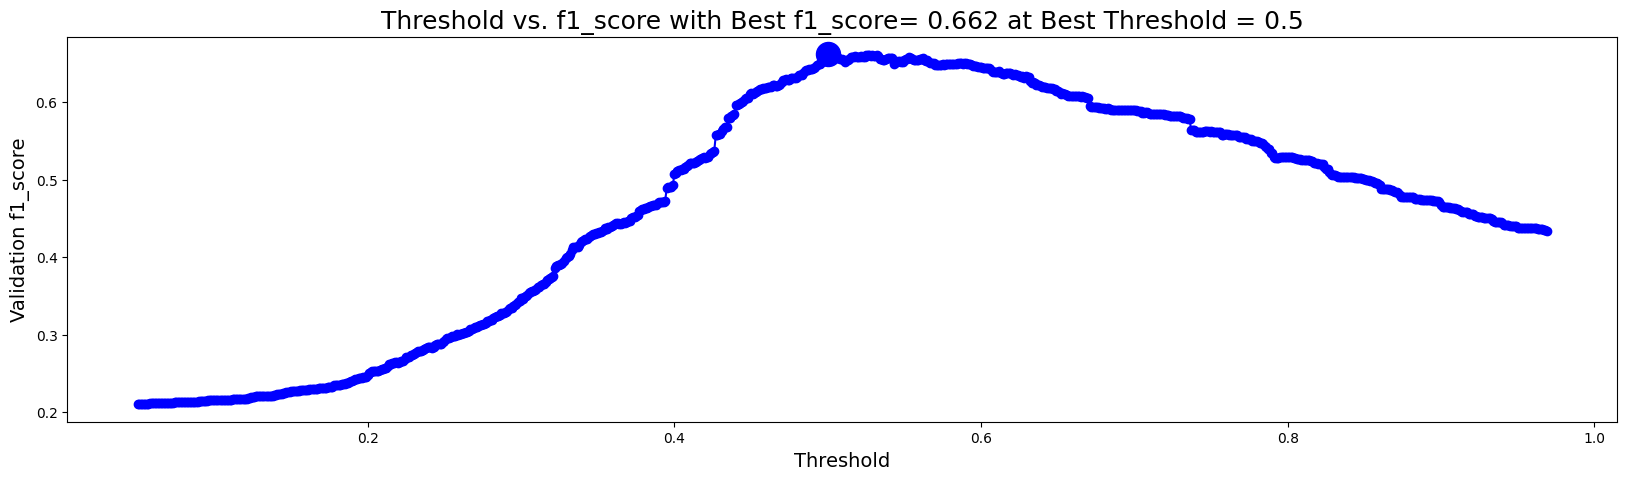

--------------------------------------------------
xgboost training fold 1
[21:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

--------------------------------------------------
xgboost training fold 2
[21:18:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

--------------------------------------------------
xgboost training fold 3
[21:18:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

--------------------------------------------------
xgboost training fold 4
[21:18:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

--------------------------------------------------
xgboost training fold 5
[21:18:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

--------------------------------------------------
xgboost training fold 6
[21:18:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

----------

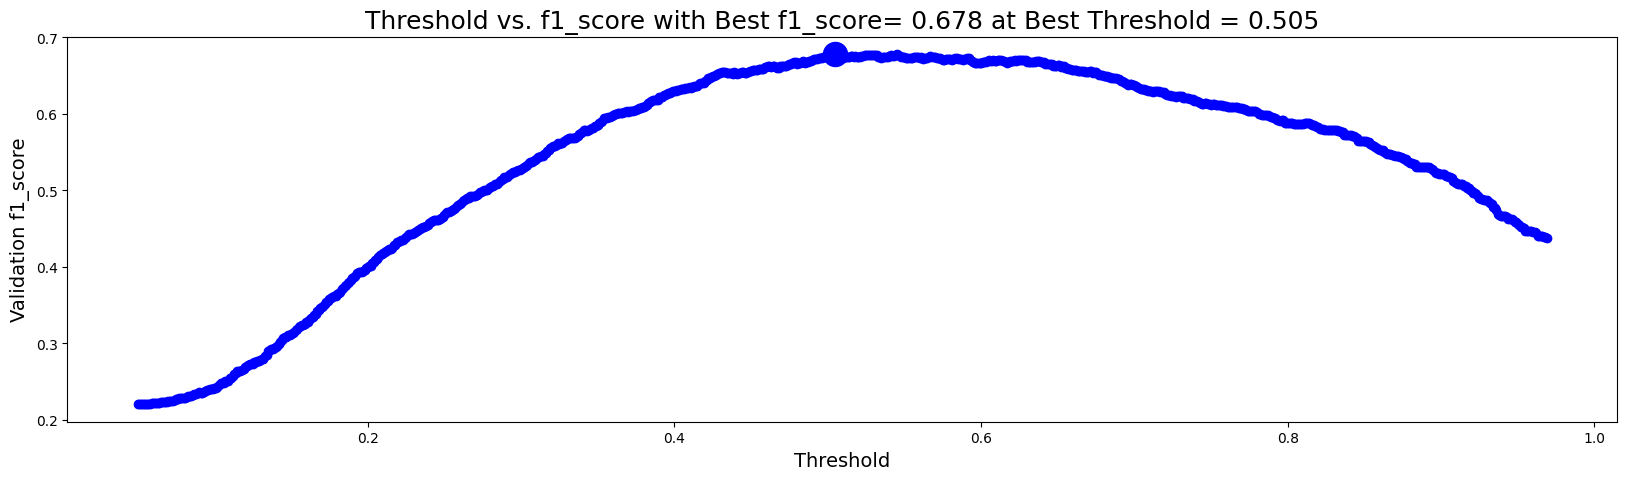

--------------------------------------------------
catboost training fold 1
--------------------------------------------------
catboost training fold 2
--------------------------------------------------
catboost training fold 3
--------------------------------------------------
catboost training fold 4
--------------------------------------------------
catboost training fold 5
--------------------------------------------------
catboost training fold 6
--------------------------------------------------
catboost training fold 7
AUC_ROC----0.7507069570404159
F1-score-----0.6733033441713461
Precision-----0.5010953393922714
Recall-----0.5788353863381859


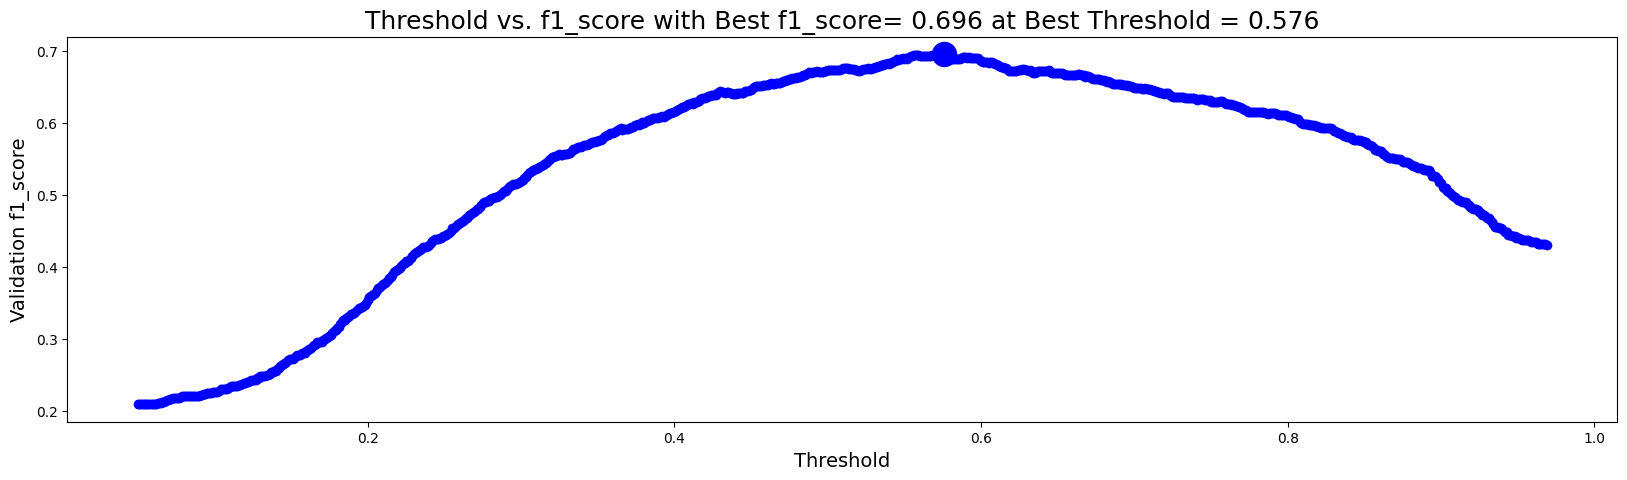

In [65]:
for method in METHOD_LIST:
    gradient_boosting_model_cv_training(method, X_train[columns], columns,best_threshold_all)

In [66]:
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_cat:
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / N_SPLITS

def lgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_lgb:
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / N_SPLITS
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_xgb:
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test[columns]))
    return test_pred / N_SPLITS

In [67]:
pred_cat = catboost_inference(X_test[columns])
pred_lgbm =lgbm_inference(X_test[columns])
pred_xgb = xgboost_inference(X_test[columns])

In [68]:
test_preds = 0.8*pred_cat+0.1*pred_lgbm+0.1*pred_xgb
pred_marks = (test_preds> np.mean(best_threshold_all)).astype('int')

In [69]:
print(precision_score(y_test, pred_marks))
print(recall_score(y_test,pred_marks))
print(f1_score(y_test, pred_marks,average='macro'))

0.5866666666666667
0.5333333333333333
0.7050335285629403
